# Digital Image Correlation


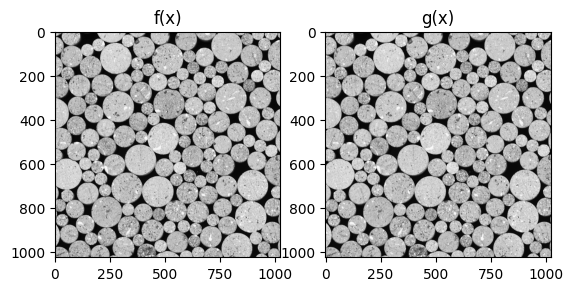

In [1]:
import tifffile
import numpy
import matplotlib.pyplot as plt

f = tifffile.imread("f(x).tif").astype(float)
g = tifffile.imread("g(x).tif").astype(float)
plt.subplot(1,2,1); plt.imshow(f, cmap='Greys_r'); plt.title("f(x)")
plt.subplot(1,2,2); plt.imshow(g, cmap='Greys_r'); plt.title("g(x)")
plt.show()

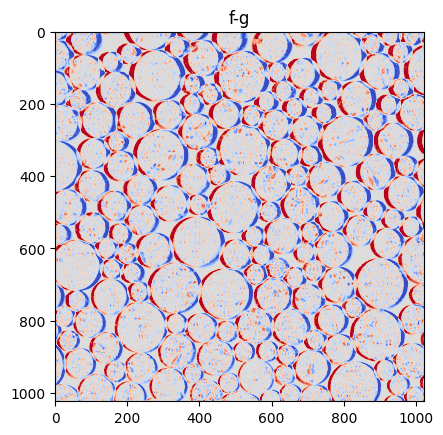

In [2]:
# Are they the same image?
plt.imshow(f-g, cmap='coolwarm', vmin=-128, vmax=128)
plt.title("f-g")
plt.show()

In [3]:
def calculateError(im1, im2):
    return numpy.sum(numpy.square( im1 - im2 )) / numpy.sum(im1)

print(calculateError(f,g))

25.940333994272205


## Rough alignment with brute-force "pixel search"

Displacement-only search in a given range, here we'll look plus of minus 5 pixels.

In [36]:
margin = 50
step = 1

search_range_x = numpy.arange(5, 15+1, step)
search_range_y = numpy.arange(-5, 5+1, step)

print(f"Search Range X:\n\t{search_range_x}")
print(f"Search Range Y:\n\t{search_range_y}")

error_map = numpy.zeros([len(search_range_y),
                         len(search_range_x)])
print(error_map.shape)

Search Range X:
	[ 5  6  7  8  9 10 11 12 13 14 15]
Search Range Y:
	[-5 -4 -3 -2 -1  0  1  2  3  4  5]
(11, 11)


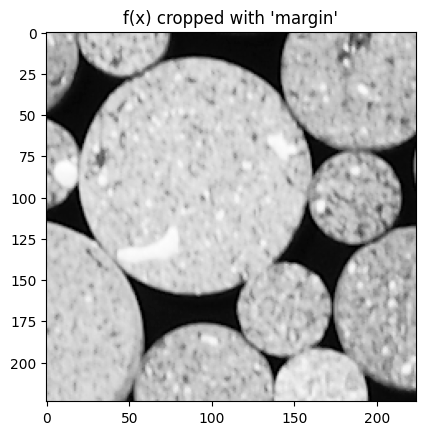

In [8]:
# Keep f(x) still, so just apply margin:
f_crop = f[margin:-margin,
           margin:-margin]

plt.imshow(f_crop, cmap='Greys_r');
plt.title("f(x) cropped with 'margin'")
plt.show()

Enumerator for the loop: 0, actual x-displacement: 5 px
Enumerator for the loop: 1, actual x-displacement: 6 px
Enumerator for the loop: 2, actual x-displacement: 7 px
Enumerator for the loop: 3, actual x-displacement: 8 px
Enumerator for the loop: 4, actual x-displacement: 9 px
Enumerator for the loop: 5, actual x-displacement: 10 px
Enumerator for the loop: 6, actual x-displacement: 11 px
Enumerator for the loop: 7, actual x-displacement: 12 px
Enumerator for the loop: 8, actual x-displacement: 13 px
Enumerator for the loop: 9, actual x-displacement: 14 px
Enumerator for the loop: 10, actual x-displacement: 15 px


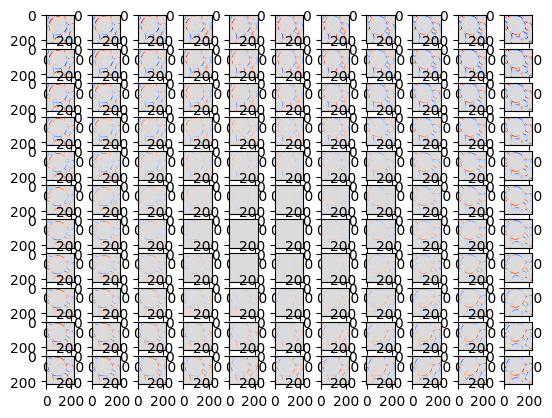

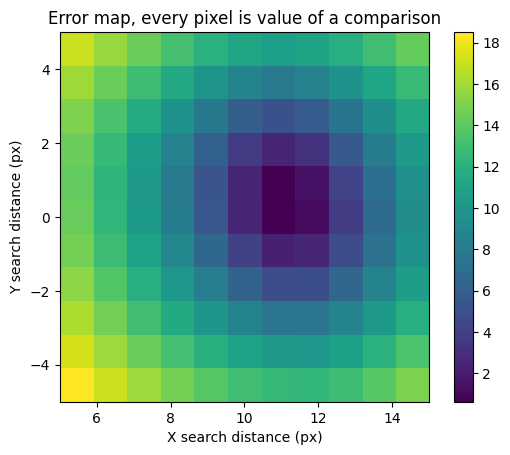

In [21]:
for xl, xd in enumerate(search_range_x):
    print(f"Enumerator for the loop: {xl}, actual x-displacement: {xd} px")
    for yl, yd in enumerate(search_range_y):
        #print('\t', yl, yd)
        g_crop = g[margin+yd:-margin+yd,
                   margin+xd:-margin+xd]
        error_map[yl, xl] = calculateError(f_crop, g_crop)
        plt.subplot(len(search_range_x), len(search_range_y), 1+xl*len(search_range_x)+yl)
        plt.imshow(f_crop-g_crop, cmap='coolwarm', vmin=-128, vmax=128)
plt.show()
        
plt.imshow(error_map,extent=[search_range_x[0], search_range_x[-1],
                             search_range_y[0], search_range_y[-1]])
plt.xlabel('X search distance (px)')
plt.ylabel('Y search distance (px)')
plt.title('Error map, every pixel is value of a comparison')
plt.colorbar()
plt.show()

In [10]:
error_min_position = numpy.where(error_map == error_map.min())
#print(error_min_position)
print(f"Displacement with lowest error: [x = {search_range_x[error_min_position[1][0]]},",
      f"y = {search_range_y[error_min_position[0][0]]}]")
print(f"Error value: {error_map.min():0.3f}")

Displacement with lowest error: [x = 11, y = 0]
Error value: 0.631


## Attempt at least-squares optimisation with x, y, and theta


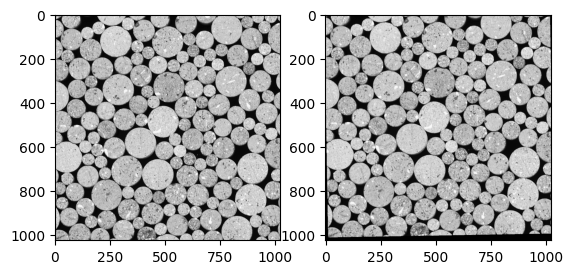

In [23]:
def deformImage(im, dx=0, dy=0, dthetaDeg=0):
    import scipy.ndimage
    imDef = numpy.zeros_like(im, dtype='<f4')
    PhiCentre = (numpy.array(im.shape) - 1) / 2.0
    dthetaRad = numpy.deg2rad(dthetaDeg)
    
    Phi = numpy.eye(3)
    Phi[0:2, 0:2] = [[ numpy.cos(dthetaRad), numpy.sin(dthetaRad)],
                     [-numpy.sin(dthetaRad), numpy.cos(dthetaRad)]]
    Phi[0,-1] = dy
    Phi[1,-1] = dx

    #PhiInv = numpy.linalg.inv(Phi).astype('<f4')
    
    coordinatesInitial = numpy.ones((3, im.shape[0] * im.shape[1]), dtype='<f4')

    coordinates_mgrid = numpy.mgrid[0:im.shape[0],
                                    0:im.shape[1]]

    # Copy into coordinatesInitial
    coordinatesInitial[0, :] = coordinates_mgrid[0].ravel() - PhiCentre[0]
    coordinatesInitial[1, :] = coordinates_mgrid[1].ravel() - PhiCentre[1]

    # Apply Phi to coordinates
    coordinatesDef = numpy.dot(Phi, coordinatesInitial)

    coordinatesDef[0, :] += PhiCentre[0]
    coordinatesDef[1, :] += PhiCentre[1]

    imDef += scipy.ndimage.map_coordinates(im,
                                           coordinatesDef[0:2],
                                           order=1).reshape(imDef.shape).astype('<f4')
    return imDef

# test it
plt.subplot(1,2,1)
plt.imshow(f, cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(deformImage(f, dx=-5, dy=20, dthetaDeg=1), cmap='Greys_r')
plt.show()

In [37]:
import scipy.optimize

def errorFromDisplacement(x0):
    dx, dy, dthetaDeg = x0
    f_crop = f[margin:-margin,
               margin:-margin]
    g_def = deformImage(g, dx=dx, dy=dy, dthetaDeg=dthetaDeg)
    g_def_crop = g_def[margin:-margin,
                       margin:-margin]
    error = calculateError(f_crop,g_def_crop)
    print(f"dx={dx:+0.3f}, dy={dy:+0.3f}, dtheta={dthetaDeg:+0.3f} -> error = {error:0.3f}")
    return error

scipy.optimize.least_squares(errorFromDisplacement,
                             [10,0,0],
                             diff_step=0.1)

dx=+10.000, dy=+0.000, dtheta=+0.000 -> error = 5.564
dx=+11.000, dy=+0.000, dtheta=+0.000 -> error = 4.447
dx=+10.000, dy=+0.100, dtheta=+0.000 -> error = 5.573
dx=+10.000, dy=+0.000, dtheta=+0.100 -> error = 4.965
dx=+11.834, dy=-0.155, dtheta=+9.829 -> error = 46.578
dx=+10.458, dy=-0.039, dtheta=+2.457 -> error = 29.906
dx=+10.115, dy=-0.010, dtheta=+0.614 -> error = 8.384
dx=+10.029, dy=-0.002, dtheta=+0.154 -> error = 4.996
dx=+11.032, dy=-0.002, dtheta=+0.154 -> error = 3.667
dx=+10.029, dy=-0.102, dtheta=+0.154 -> error = 4.945
dx=+10.029, dy=-0.002, dtheta=+0.254 -> error = 5.221
dx=+10.106, dy=-0.032, dtheta=+0.021 -> error = 5.109
dx=+10.048, dy=-0.010, dtheta=+0.120 -> error = 4.906
dx=+11.053, dy=-0.010, dtheta=+0.120 -> error = 3.636
dx=+10.048, dy=-0.110, dtheta=+0.120 -> error = 4.857
dx=+10.048, dy=-0.010, dtheta=+0.220 -> error = 5.038
dx=+10.100, dy=-0.030, dtheta=+0.066 -> error = 4.843
dx=+11.110, dy=-0.030, dtheta=+0.066 -> error = 3.712
dx=+10.100, dy=-0.130, dth

 active_mask: array([0., 0., 0.])
        cost: 7.964693681676828
         fun: array([3.991])
        grad: array([-2.253,  1.248,  6.327])
         jac: array([[-0.564,  0.313,  1.585]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 29
        njev: 12
  optimality: 6.32712730117028
      status: 3
     success: True
           x: array([10.574, -0.222,  0.127])

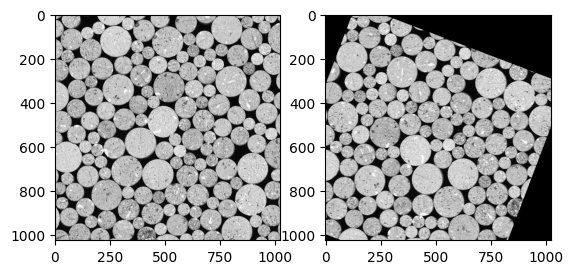

In [33]:
badG = deformImage(g, dx=123.969, dy=33.432, dthetaDeg=69.159)
plt.subplot(1,2,1)
plt.imshow(f, cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(badG, cmap='Greys_r')
plt.show()

## Full mathematical optimisation, developing newton's method on image


In [38]:
import spam.DIC
import spam.deformation

PhiInit = numpy.eye(4)
PhiInit[2,-1] = 10

PhiOut = spam.DIC.register(f, g, margin=margin, verbose=True, PhiRigid=True, imShowProgress=0, PhiInit=PhiInit)
print(f"translation (x, y): {spam.deformation.decomposePhi(PhiOut['Phi'])['t'][1:3][::-1]}")
print(f"rotation: {spam.deformation.decomposePhi(PhiOut['Phi'])['r'][0]}")

Start correlation with Error = 5.56



	 -> Converged
translation (x, y): [11.472 -0.446]
rotation: -0.1167009761636308


In [40]:
PhiOut = spam.DIC.registerMultiscale(f, g, 16, margin=margin, verbose=True, PhiRigid=True, imShowProgress=0, PhiInit=None)
print(f"translation (x, y): {spam.deformation.decomposePhi(PhiOut['Phi'])['t'][1:3][::-1]}")
print(f"rotation: {spam.deformation.decomposePhi(PhiOut['Phi'])['r'][0]}")

spam.DIC.correlate.registerMultiscale(): working on binning:  16
Start correlation with Error = 26.28

	 -> Converged
spam.DIC.correlate.registerMultiscale(): working on binning:  8
Start correlation with Error = 4.91

	 -> Converged
spam.DIC.correlate.registerMultiscale(): working on binning:  4
Start correlation with Error = 2.76

	 -> Converged
spam.DIC.correlate.registerMultiscale(): working on binning:  2
Start correlation with Error = 2.75



	 -> Converged
spam.DIC.correlate.registerMultiscale(): working on binning:  1
Start correlation with Error = 3.31



	 -> Converged
translation (x, y): [11.472 -0.446]
rotation: -0.11696689911573377
